In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx
/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx
/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv


In [5]:
!pip install openpyxl


In [6]:
df_inf = pd.read_csv("/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_infertility.csv")
df_woinf = pd.read_excel("/kaggle/input/polycystic-ovary-syndrome-pcos/PCOS_data_without_infertility.xlsx",sheet_name="Full_new")

In [7]:
df_inf.head()


,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [8]:
#Look at the data with non-infertile patients.
df_woinf.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [9]:
#Look at the columns of data with non-infertile patients.
df_woinf.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [10]:
# Merge on Patient File No.
data = pd.merge(
    df_woinf,
    df_inf,
    on="Patient File No.",
    how="left",
    suffixes=("", "_wo")
)

# Columns that may or may not exist → drop safely
cols_to_drop = [
    "Unnamed: 44",
    "Sl. No_wo",
    "PCOS (Y/N)_wo",
    "I   beta-HCG(mIU/mL)_wo",
    "II    beta-HCG(mIU/mL)_wo",
    "AMH(ng/mL)_wo"
]

data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

# Rename main target column
data = data.rename(columns={"PCOS (Y/N)": "Target"})

# Preview result
data.head()

,Sl. No,Patient File No.,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),I beta-HCG(mIU/mL)_wo
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [11]:
data = data.drop(["Sl. No","Patient File No."],axis = 1)


In [12]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Target                     541 non-null    int64  
 1    Age (yrs)                 541 non-null    int64  
 2   Weight (Kg)                541 non-null    float64
 3   Height(Cm)                 541 non-null    float64
 4   BMI                        541 non-null    float64
 5   Blood Group                541 non-null    int64  
 6   Pulse rate(bpm)            541 non-null    int64  
 7   RR (breaths/min)           541 non-null    int64  
 8   Hb(g/dl)                   541 non-null    float64
 9   Cycle(R/I)                 541 non-null    int64  
 10  Cycle length(days)         541 non-null    int64  
 11  Marraige Status (Yrs)      540 non-null    float64
 12  Pregnant(Y/N)              541 non-null    int64  
 13  No. of aborptions          541 non-null    int64  

In [13]:
data["AMH(ng/mL)"].head() 


0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [14]:
data["II    beta-HCG(mIU/mL)"].head()


0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [15]:
#Converting
data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

In [16]:
colors = ['#670067','#008080']


In [17]:
def bar_plot(variable):
    """
     input: variable example : Target
     output: bar plot & value count
     
    """
    #get feature
    var = data[variable]
    #count number of categorical variable(value/sample)
    varValue = var.value_counts()
    #visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=colors)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

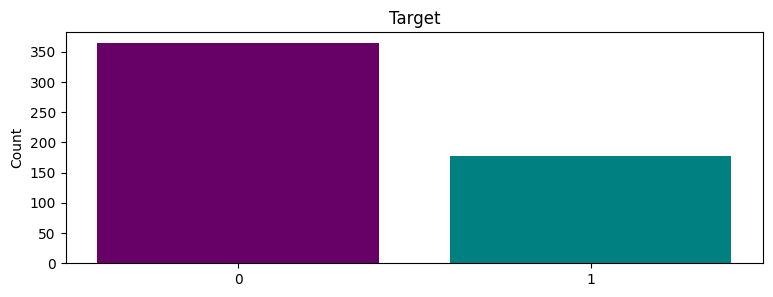

Target: 
 Target
0    364
1    177
Name: count, dtype: int64


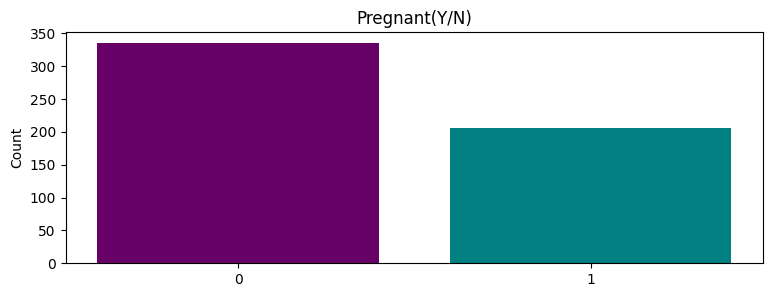

Pregnant(Y/N): 
 Pregnant(Y/N)
0    335
1    206
Name: count, dtype: int64


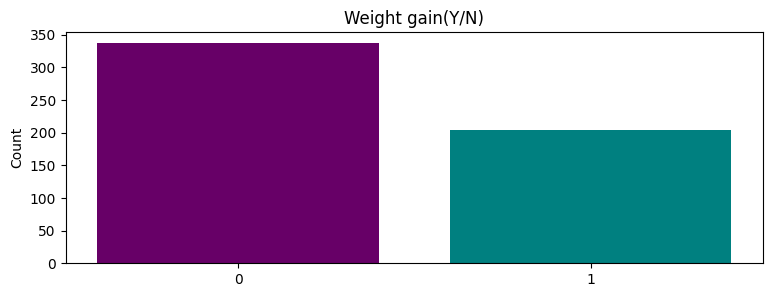

Weight gain(Y/N): 
 Weight gain(Y/N)
0    337
1    204
Name: count, dtype: int64


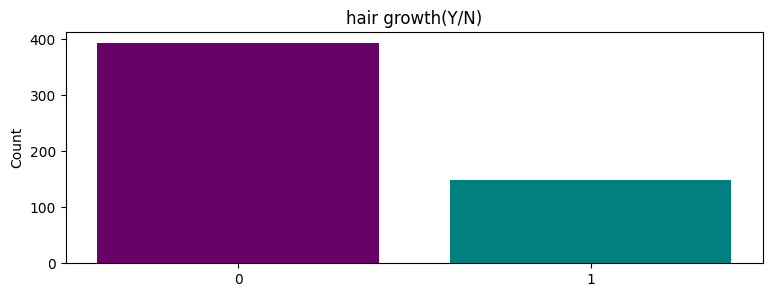

hair growth(Y/N): 
 hair growth(Y/N)
0    393
1    148
Name: count, dtype: int64


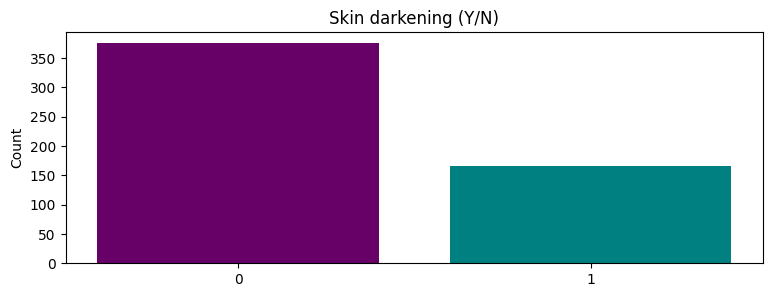

Skin darkening (Y/N): 
 Skin darkening (Y/N)
0    375
1    166
Name: count, dtype: int64


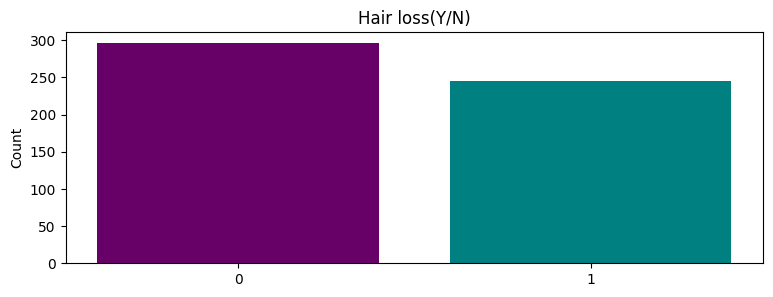

Hair loss(Y/N): 
 Hair loss(Y/N)
0    296
1    245
Name: count, dtype: int64


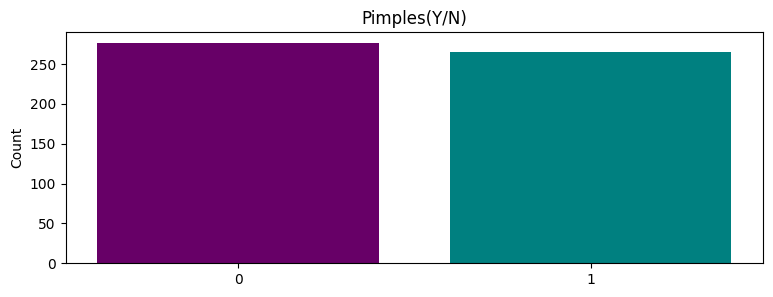

Pimples(Y/N): 
 Pimples(Y/N)
0    276
1    265
Name: count, dtype: int64


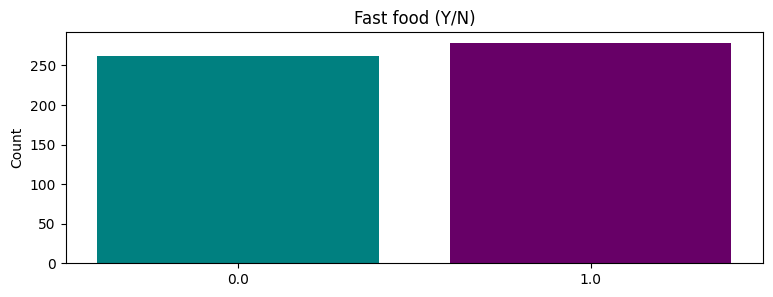

Fast food (Y/N): 
 Fast food (Y/N)
1.0    278
0.0    262
Name: count, dtype: int64


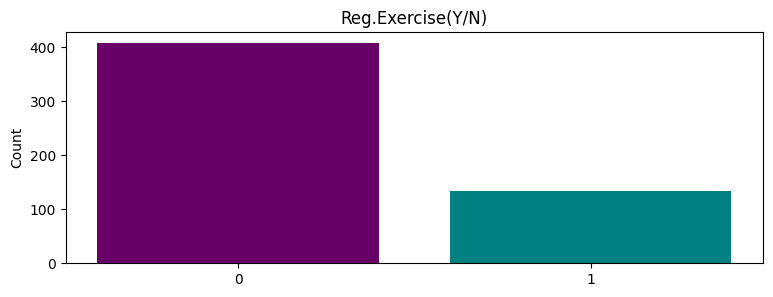

Reg.Exercise(Y/N): 
 Reg.Exercise(Y/N)
0    407
1    134
Name: count, dtype: int64


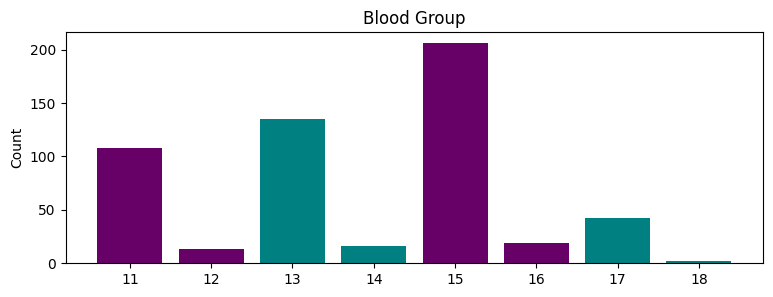

Blood Group: 
 Blood Group
15    206
13    135
11    108
17     42
16     19
14     16
12     13
18      2
Name: count, dtype: int64


In [18]:
category = ["Target", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", 
            "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)", "Blood Group"]
for c in category:
    bar_plot(c)

In [19]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50,color=colors[0])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

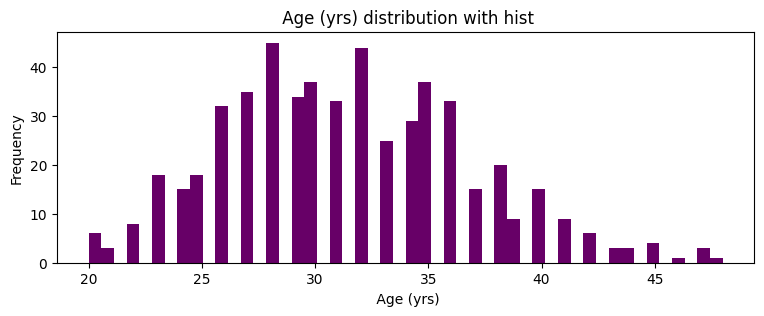

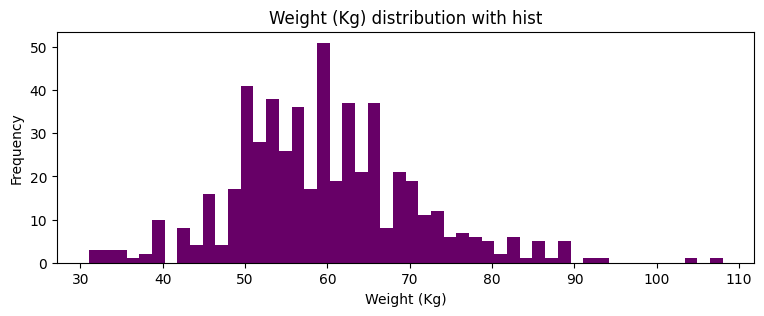

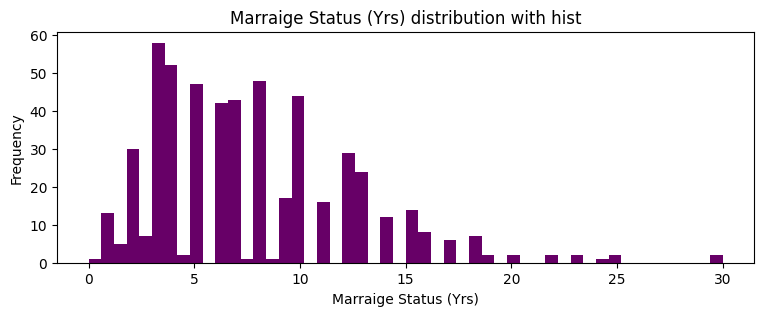

In [20]:
numericVar = [" Age (yrs)", "Weight (Kg)","Marraige Status (Yrs)"]
for n in numericVar:
    plot_hist(n)

In [21]:
data.columns[data.isnull().any()]


Index(['Marraige Status (Yrs)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)',
       'Fast food (Y/N)', '  I   beta-HCG(mIU/mL)_wo'],
      dtype='object')

In [22]:
#Filling missing values with the median value of the features.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

In [23]:
data.isnull().sum()


Target                         0
 Age (yrs)                     0
Weight (Kg)                    0
Height(Cm)                     0
BMI                            0
Blood Group                    0
Pulse rate(bpm)                0
RR (breaths/min)               0
Hb(g/dl)                       0
Cycle(R/I)                     0
Cycle length(days)             0
Marraige Status (Yrs)          0
Pregnant(Y/N)                  0
No. of aborptions              0
  I   beta-HCG(mIU/mL)         0
II    beta-HCG(mIU/mL)         0
FSH(mIU/mL)                    0
LH(mIU/mL)                     0
FSH/LH                         0
Hip(inch)                      0
Waist(inch)                    0
Waist:Hip Ratio                0
TSH (mIU/L)                    0
AMH(ng/mL)                     0
PRL(ng/mL)                     0
Vit D3 (ng/mL)                 0
PRG(ng/mL)                     0
RBS(mg/dl)                     0
Weight gain(Y/N)               0
hair growth(Y/N)               0
Skin darke

In [24]:
data.describe()


,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),I beta-HCG(mIU/mL)_wo
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,0.0
mean,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,11.160037,2.560074,...,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915,NaN
std,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,0.866904,0.901950,...,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381,NaN
min,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,...,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,10.500000,2.000000,...,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000,NaN
50%,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,...,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000,NaN
75%,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,11.700000,4.000000,...,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000,NaN
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,...,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000,NaN


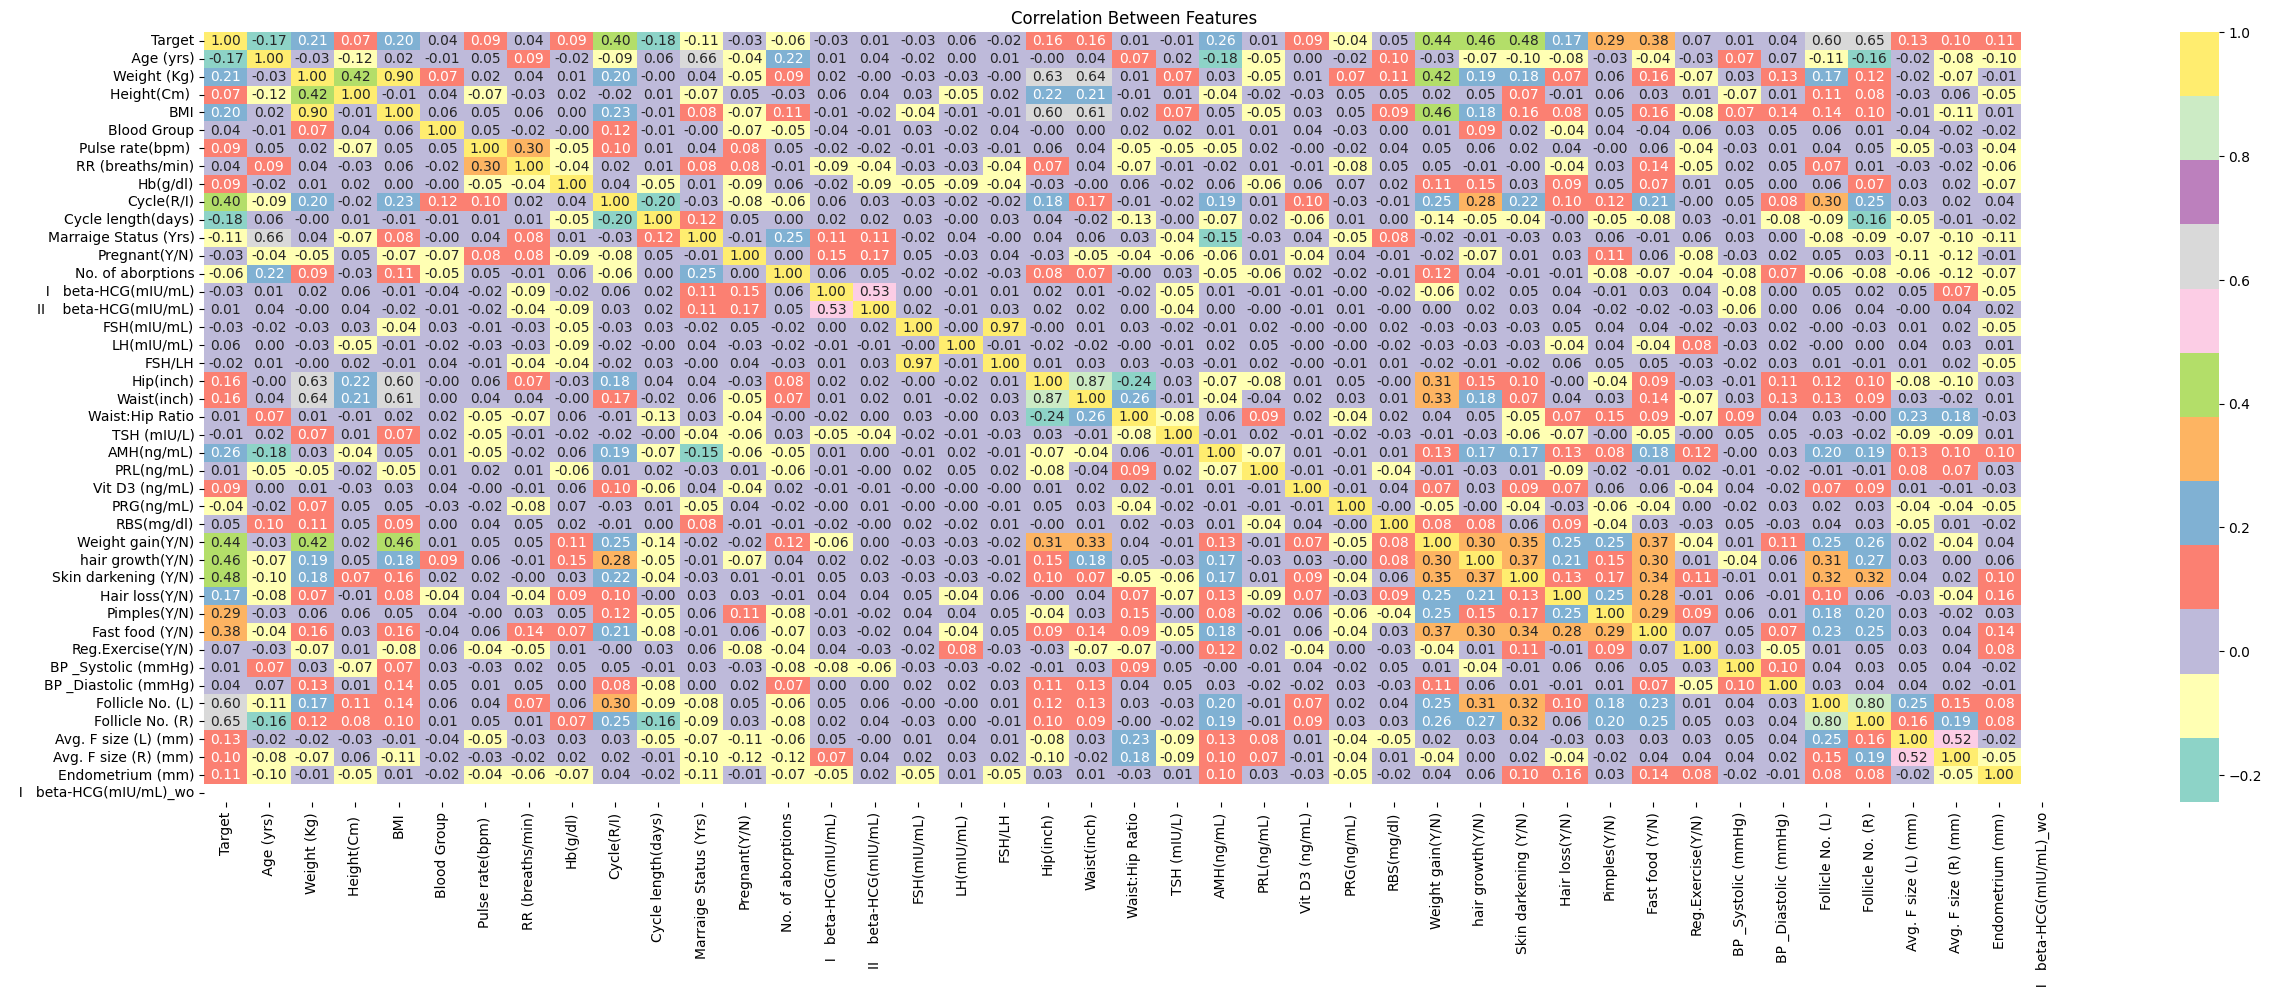

In [25]:
corr_matrix= data.corr()
plt.subplots(figsize=(30,10))
sns.heatmap(corr_matrix,cmap="Set3", annot = True, fmt = ".2f");
plt.title("Correlation Between Features")
plt.show()

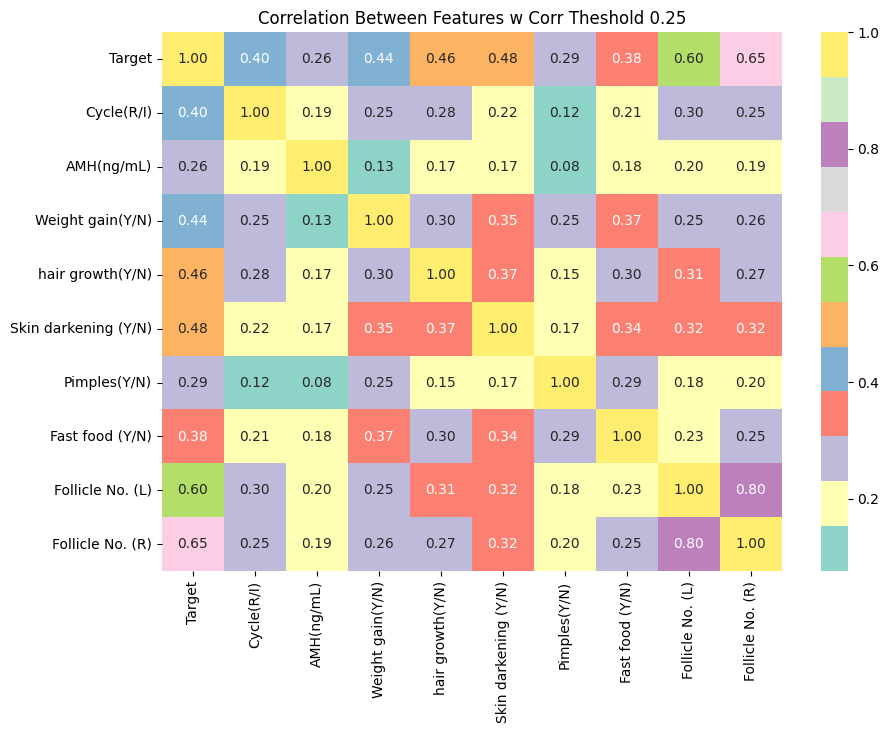

In [27]:
threshold = 0.25 
filtre = np.abs(corr_matrix["Target"]) > threshold 
corr_features = corr_matrix.columns[filtre].tolist()
plt.subplots(figsize=(10,7))
sns.heatmap(data[corr_features].corr(),cmap="Set3", annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.25")
plt.show()

In [28]:
X= data.drop(labels = ["Target"],axis = 1)
y=data.Target

In [29]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) 


In [30]:
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 378
X_test 163
y_train 378
y_test 163


In [31]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# 1) Impute missing values (use median for numeric features)
imputer = SimpleImputer(strategy='median')

# Fit on train, transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

# 2) Train Logistic Regression on the imputed data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_imputed, y_train)

# 3) Evaluate
acc_log_train = round(logreg.score(X_train_imputed, y_train) * 100, 2)
acc_log_test  = round(logreg.score(X_test_imputed, y_test) * 100, 2)

print("Training Accuracy: % {}".format(acc_log_train))
print("Testing  Accuracy: % {}".format(acc_log_test))


Training Accuracy: % 93.12
Testing  Accuracy: % 86.5


In [32]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[300,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}


classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1) Impute missing values (fit on train, transform train & test)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

# 2) GridSearch for all classifiers using the imputed X
cv_result = []
best_estimators = []

for i, (base_clf, param_grid) in enumerate(zip(classifier, classifier_param)):
    print(f"\n===== Model {i+1}: {base_clf.__class__.__name__} =====")

    clf = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=10),
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )

    clf.fit(X_train_imputed, y_train)          # 👈 use imputed data here

    best_score = round(clf.best_score_ * 100, 2)
    cv_result.append(best_score)
    best_estimators.append(clf.best_estimator_)

    print(f"Best CV Accuracy: {best_score} %")
    print(f"Best Params: {clf.best_params_}")



===== Model 1: DecisionTreeClassifier =====
Fitting 10 folds for each of 250 candidates, totalling 2500 fits
Best CV Accuracy: 86.51 %
Best Params: {'max_depth': 3, 'min_samples_split': 10}

===== Model 2: SVC =====
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Best CV Accuracy: 69.57 %
Best Params: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

===== Model 3: RandomForestClassifier =====
Fitting 10 folds for each of 48 candidates, totalling 480 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best CV Accuracy: 91.27 %
Best Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}

===== Model 4: LogisticRegression =====
Fitting 10 folds for each of 14 candidates, totalling 140 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best CV Accuracy: 85.98 %
Best Params: {'C': 1000.0, 'penalty': 'l2'}

===== Model 5: KNeighborsClassifier =====
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best CV Accuracy: 73.79 %
Best Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [34]:
best_estimators


[DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42),
 SVC(C=1, gamma=0.001, random_state=42),
 RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=500,
                        random_state=42),
 LogisticRegression(C=1000.0, random_state=42),
 KNeighborsClassifier(metric='manhattan', weights='distance')]

In [35]:
dt = best_estimators[0]
svm = best_estimators[1]
rf = best_estimators[2]
lr = best_estimators[3]
knn = best_estimators[4]

In [36]:
# xgbrf classifier
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=random_state)
xgb_clf.fit(X_train,y_train)
acc_xgb_clf_train = round(xgb_clf.score(X_train, y_train)*100,2) 
acc_xgb_clf_test = round(xgb_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_xgb_clf_train)
print("Training Accuracy: % {}".format(acc_xgb_clf_train))
print("Testing Accuracy: % {}".format(acc_xgb_clf_test))

Training Accuracy: % 92.06
Testing Accuracy: % 87.12


In [37]:
#CatBoost Classifier
cat_clf = CatBoostClassifier()
cat_clf.fit(X_train,y_train)
acc_cat_clf_train = round(cat_clf.score(X_train, y_train)*100,2) 
acc_cat_clf_test = round(cat_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_cat_clf_train)
print("Training Accuracy: % {}".format(acc_cat_clf_train))
print("Testing Accuracy: % {}".format(acc_cat_clf_test))

Learning rate set to 0.0068
0:	learn: 0.6865757	total: 57.6ms	remaining: 57.6s
1:	learn: 0.6795200	total: 59.8ms	remaining: 29.8s
2:	learn: 0.6737906	total: 62.2ms	remaining: 20.7s
3:	learn: 0.6677745	total: 64.4ms	remaining: 16s
4:	learn: 0.6638175	total: 66.6ms	remaining: 13.3s
5:	learn: 0.6571682	total: 68.6ms	remaining: 11.4s
6:	learn: 0.6509558	total: 70.7ms	remaining: 10s
7:	learn: 0.6453631	total: 72.8ms	remaining: 9.03s
8:	learn: 0.6402678	total: 74.9ms	remaining: 8.24s
9:	learn: 0.6359401	total: 76.2ms	remaining: 7.54s
10:	learn: 0.6306277	total: 78.6ms	remaining: 7.06s
11:	learn: 0.6264775	total: 80.8ms	remaining: 6.66s
12:	learn: 0.6195728	total: 83ms	remaining: 6.3s
13:	learn: 0.6145687	total: 85.1ms	remaining: 6s
14:	learn: 0.6104505	total: 87.4ms	remaining: 5.74s
15:	learn: 0.6050904	total: 89.4ms	remaining: 5.5s
16:	learn: 0.5999491	total: 91.6ms	remaining: 5.29s
17:	learn: 0.5953040	total: 93.8ms	remaining: 5.12s
18:	learn: 0.5911944	total: 95.9ms	remaining: 4.95s
19:	l

In [38]:
model_list = ['Decision Tree','SVC','RandomForest','Logistic Regression','KNearestNeighbours','XGBRF','CatBoostClassifier']

In [40]:
import plotly.graph_objects as go
# create trace1
trace1 = go.Bar(
                x = model_list,
                y = cv_result,
                marker = dict(color = 'rgb(0, 128, 128)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(title = 'Accuracy of different Classifier Models' , xaxis = dict(title = 'Classifier Models'), yaxis = dict(title = '% of Accuracy'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

In [41]:
model = [dt,svm,rf,lr,knn,xgb_clf,cat_clf]
predictions = []

Learning rate set to 0.0068
0:	learn: 0.6865746	total: 7.09ms	remaining: 7.08s
1:	learn: 0.6799814	total: 10.9ms	remaining: 5.42s
2:	learn: 0.6744893	total: 13.3ms	remaining: 4.43s
3:	learn: 0.6681976	total: 15.9ms	remaining: 3.95s
4:	learn: 0.6616683	total: 18.2ms	remaining: 3.62s
5:	learn: 0.6558050	total: 20.5ms	remaining: 3.39s
6:	learn: 0.6493724	total: 22.9ms	remaining: 3.25s
7:	learn: 0.6449122	total: 25.3ms	remaining: 3.13s
8:	learn: 0.6402048	total: 27.6ms	remaining: 3.04s
9:	learn: 0.6355092	total: 29.9ms	remaining: 2.96s
10:	learn: 0.6286298	total: 32.3ms	remaining: 2.9s
11:	learn: 0.6233711	total: 34.5ms	remaining: 2.84s
12:	learn: 0.6187507	total: 36.9ms	remaining: 2.8s
13:	learn: 0.6132194	total: 40.6ms	remaining: 2.86s
14:	learn: 0.6077014	total: 44.7ms	remaining: 2.94s
15:	learn: 0.6035414	total: 48.3ms	remaining: 2.97s
16:	learn: 0.5982889	total: 51.1ms	remaining: 2.96s
17:	learn: 0.5950538	total: 54.6ms	remaining: 2.98s
18:	learn: 0.5893045	total: 57.5ms	remaining: 2.

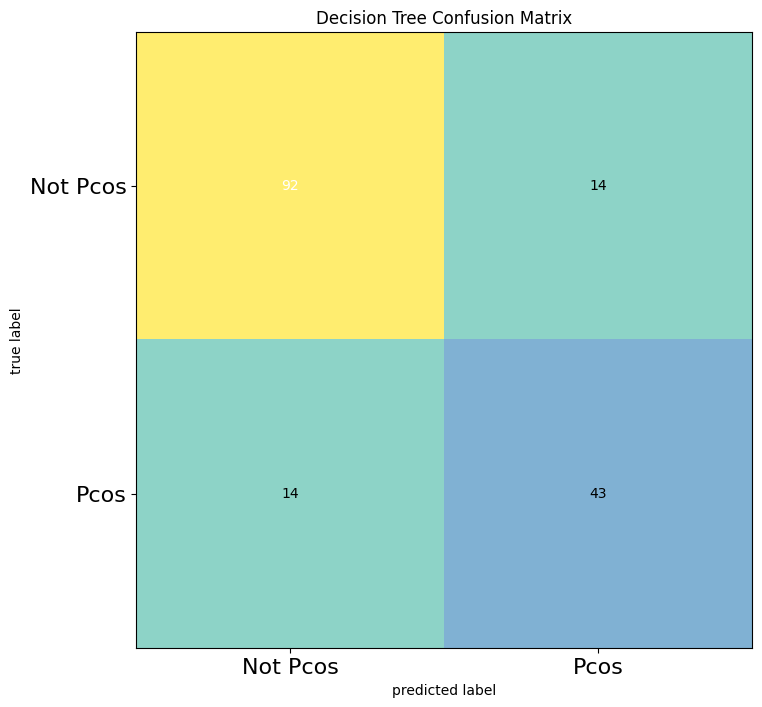

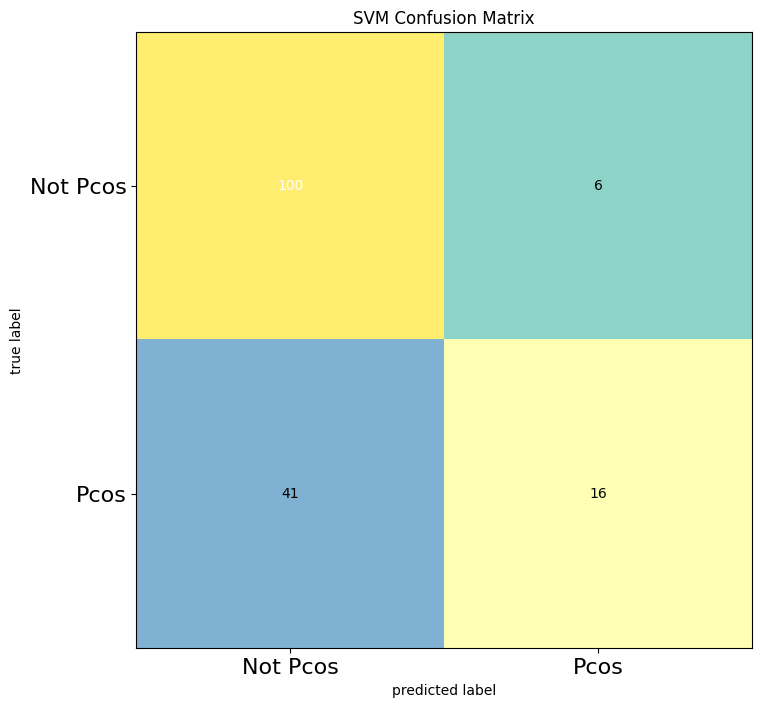

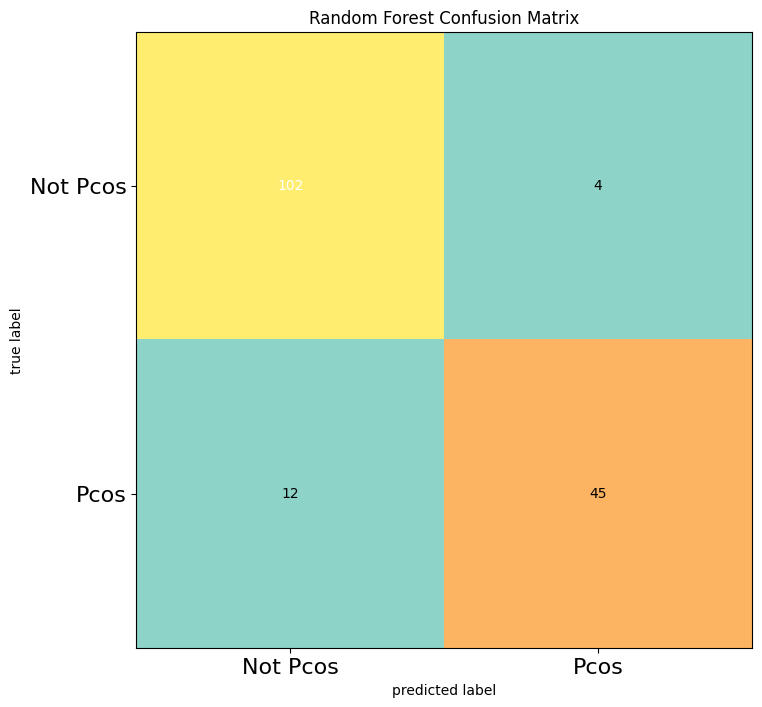

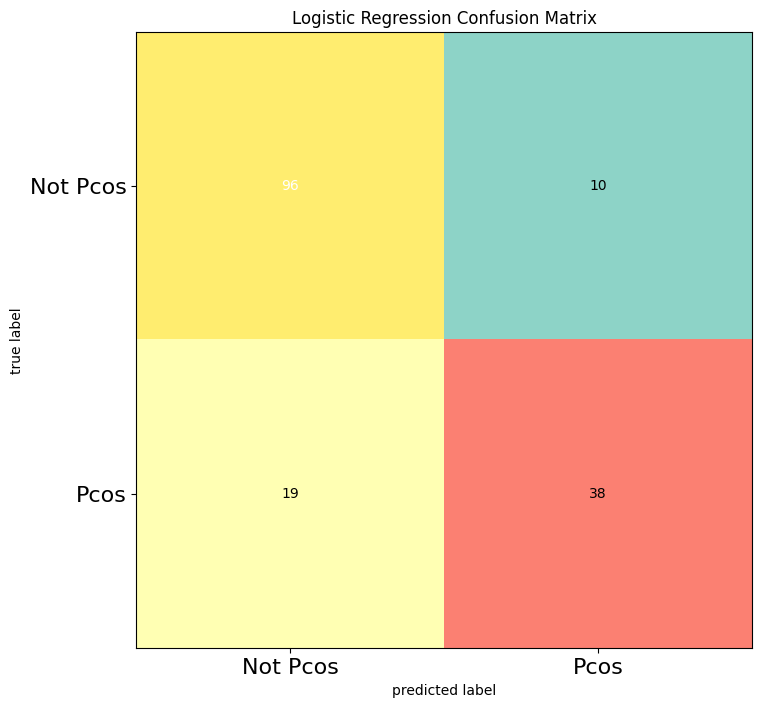

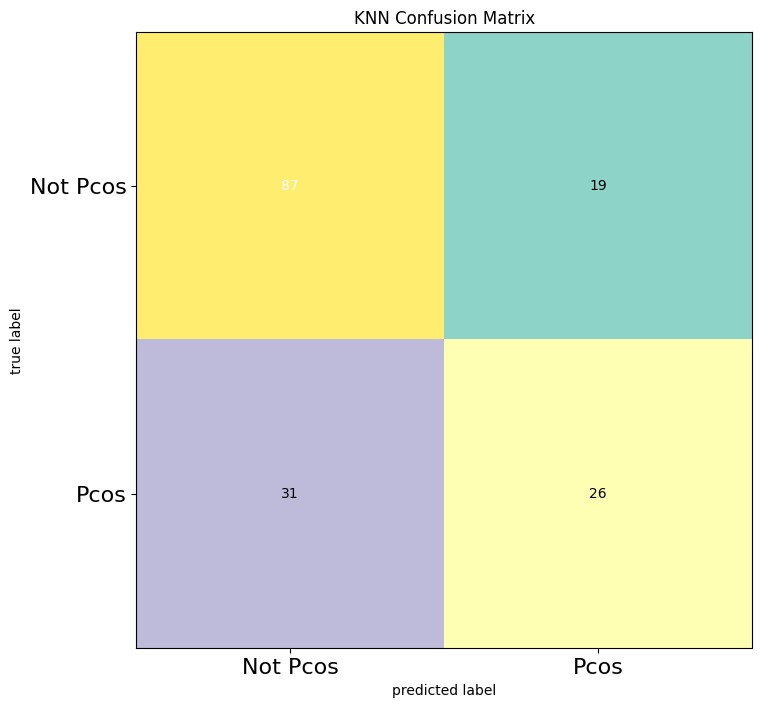

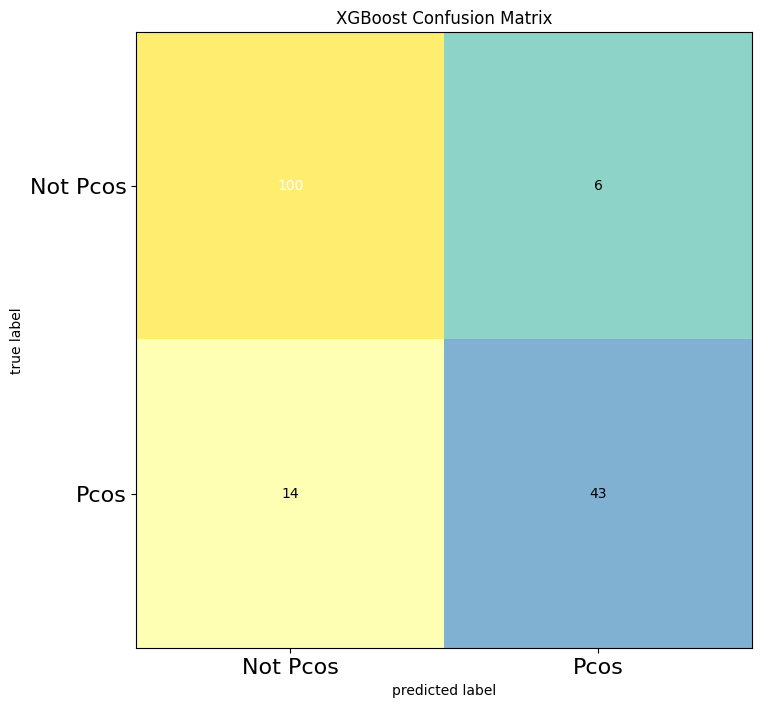

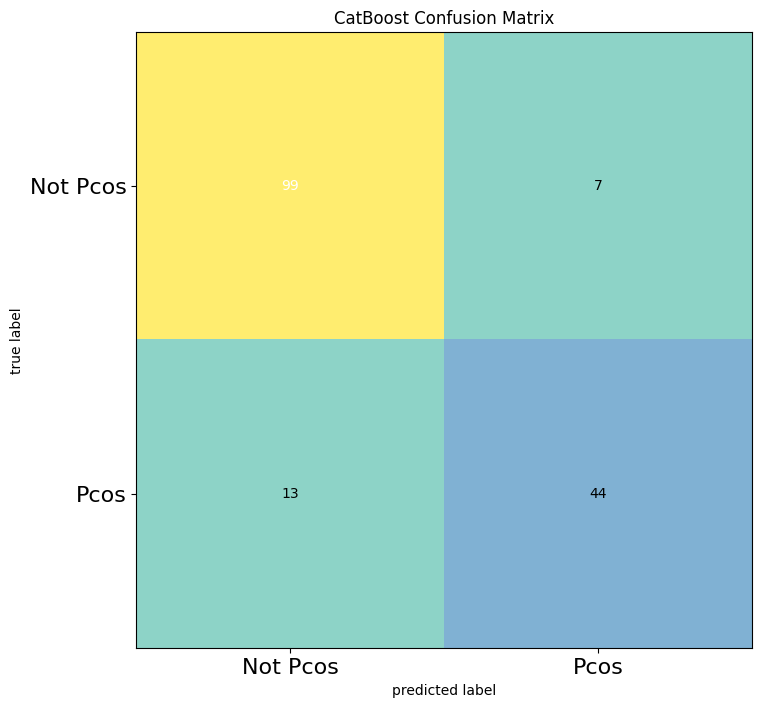

In [42]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

# 1️⃣ Impute (if already done earlier, this will just redo consistently on the current X)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

# 2️⃣ Refit XGBoost & CatBoost on the CURRENT feature set (41 cols)
#    (Other models like dt, svm, rf, lr, knn were likely already fit correctly,
#     but refitting these two ensures no feature mismatch.)

# If you haven't imported them earlier, uncomment these:
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

xgb_clf.fit(X_train_imputed, y_train)
cat_clf.fit(X_train_imputed, y_train)

# 3️⃣ Collect all models
model = [dt, svm, rf, lr, knn, xgb_clf, cat_clf]

model_list = [
    "Decision Tree",
    "SVM",
    "Random Forest",
    "Logistic Regression",
    "KNN",
    "XGBoost",
    "CatBoost"
]

# 4️⃣ Predictions on IMPTUTED test data
predictions = []
for clf in model:
    y_pred = clf.predict(X_test_imputed)   # ✅ now all models see same 41-feature input
    predictions.append(y_pred)

# 5️⃣ Plot confusion matrices
for j in range(len(model)):
    cm = confusion_matrix(y_test, predictions[j])
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Set3)
    plt.title(f"{model_list[j]} Confusion Matrix")
    plt.xticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.yticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.show()


In [43]:
import numpy as np
import pandas as pd

# 0️⃣ If imputer is not defined for some reason, create & fit it
from sklearn.impute import SimpleImputer

try:
    imputer
except NameError:
    imputer = SimpleImputer(strategy="median")
    imputer.fit(X)   # fit on full feature data

# 1️⃣ Final models and names (you already trained these)
models = [dt, svm, rf, lr, knn, xgb_clf, cat_clf]
model_names = [
    "Decision Tree",
    "SVM",
    "Random Forest",
    "Logistic Regression",
    "KNN",
    "XGBoost",
    "CatBoost"
]

# 2️⃣ Define sample patients (based on typical PCOS features in this dataset)
#    ⚠️ Column names must match your X.columns. Adjust if any name is different.
patient_examples = {
    "Case 1 - Likely PCOS": {
        "Age (yrs)": 24,
        "Weight (Kg)": 72,
        "Height(Cm)": 160,
        "BMI": 28.1,                     # Overweight
        "Cycle length(days)": 45,        # Long / irregular cycle
        "Cycle(R/I)": 1,                 # 1 = Irregular (if encoded that way)
        "Follicle No. (L)": 20,
        "Follicle No. (R)": 18,
        "Waist(inch)": 34,
        "Hip(inch)": 38,
        "Waist:Hip Ratio": 34/38,
        "Skin darkening (Y/N)": 1,
        "hair growth(Y/N)": 1,
        "Pimples(Y/N)": 1,
        "Fast food (Y/N)": 1,
        "Reg.Exercise(Y/N)": 0
    },
    "Case 2 - Likely Non-PCOS": {
        "Age (yrs)": 22,
        "Weight (Kg)": 54,
        "Height(Cm)": 162,
        "BMI": 20.6,                     # Normal
        "Cycle length(days)": 28,        # Normal cycle
        "Cycle(R/I)": 0,                 # 0 = Regular (if encoded that way)
        "Follicle No. (L)": 6,
        "Follicle No. (R)": 7,
        "Waist(inch)": 28,
        "Hip(inch)": 37,
        "Waist:Hip Ratio": 28/37,
        "Skin darkening (Y/N)": 0,
        "hair growth(Y/N)": 0,
        "Pimples(Y/N)": 0,
        "Fast food (Y/N)": 0,
        "Reg.Exercise(Y/N)": 1
    }
}

# 3️⃣ Helper to build full row aligned with X.columns
def build_row(sample_values, X_columns):
    row = {}
    for col in X_columns:
        # if we provided a value, use it; otherwise leave as NaN (imputer will fill)
        row[col] = sample_values.get(col, np.nan)
    return pd.DataFrame([row])

# 4️⃣ Run predictions for each patient and each model
for case_name, features in patient_examples.items():
    print("="*60)
    print(case_name)
    print("Input features (subset):")
    print(features)
    print()

    # Build row and impute
    sample_df = build_row(features, X.columns)
    sample_imputed = imputer.transform(sample_df)

    # Predict with all models
    for mdl, mdl_name in zip(models, model_names):
        pred = mdl.predict(sample_imputed)[0]

        if hasattr(mdl, "predict_proba"):
            prob = mdl.predict_proba(sample_imputed)[0, 1]
            prob_text = f" (PCOS probability = {prob:.2f})"
        else:
            prob_text = ""

        label = "PCOS" if pred == 1 else "No PCOS"
        print(f"{mdl_name:20s} → Prediction: {label}{prob_text}")

    print()


Case 1 - Likely PCOS
Input features (subset):
{'Age (yrs)': 24, 'Weight (Kg)': 72, 'Height(Cm)': 160, 'BMI': 28.1, 'Cycle length(days)': 45, 'Cycle(R/I)': 1, 'Follicle No. (L)': 20, 'Follicle No. (R)': 18, 'Waist(inch)': 34, 'Hip(inch)': 38, 'Waist:Hip Ratio': 0.8947368421052632, 'Skin darkening (Y/N)': 1, 'hair growth(Y/N)': 1, 'Pimples(Y/N)': 1, 'Fast food (Y/N)': 1, 'Reg.Exercise(Y/N)': 0}

Decision Tree        → Prediction: PCOS (PCOS probability = 0.70)
SVM                  → Prediction: No PCOS
Random Forest        → Prediction: PCOS (PCOS probability = 0.82)
Logistic Regression  → Prediction: PCOS (PCOS probability = 0.98)
KNN                  → Prediction: No PCOS (PCOS probability = 0.40)
XGBoost              → Prediction: PCOS (PCOS probability = 0.77)
CatBoost             → Prediction: PCOS (PCOS probability = 0.96)

Case 2 - Likely Non-PCOS
Input features (subset):
{'Age (yrs)': 22, 'Weight (Kg)': 54, 'Height(Cm)': 162, 'BMI': 20.6, 'Cycle length(days)': 28, 'Cycle(R/I)': 0

In [44]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# 1️⃣ Make sure we have an imputer fitted on X
try:
    imputer
except NameError:
    imputer = SimpleImputer(strategy="median")
    imputer.fit(X)

# 2️⃣ List of models and their names
models = [dt, svm, rf, lr, knn, xgb_clf, cat_clf]
model_names = [
    "Decision Tree",
    "SVM",
    "Random Forest",
    "Logistic Regression",
    "KNN",
    "XGBoost",
    "CatBoost"
]

print("Please answer the following questions about the patient:\n")

# 3️⃣ Ask you questions and collect input
sample_values = {}

# Numeric inputs
def ask_float(col_name, prompt):
    while True:
        val = input(prompt)
        try:
            return float(val)
        except:
            print("Please enter a valid number.")

sample_values['Age (yrs)']           = ask_float('Age (yrs)', "Age in years: ")
sample_values['Weight (Kg)']         = ask_float('Weight (Kg)', "Weight (Kg): ")
sample_values['Height(Cm)']          = ask_float('Height(Cm)', "Height (cm): ")

# BMI – either ask directly or compute
use_auto_bmi = input("Do you want BMI to be auto-calculated from weight and height? (y/n): ").strip().lower()
if use_auto_bmi.startswith('y'):
    h_m = sample_values['Height(Cm)'] / 100.0
    bmi = sample_values['Weight (Kg)'] / (h_m**2) if h_m > 0 else np.nan
    print(f"Calculated BMI = {bmi:.2f}")
    sample_values['BMI'] = bmi
else:
    sample_values['BMI'] = ask_float('BMI', "BMI: ")

sample_values['Cycle length(days)']  = ask_float('Cycle length(days)', "Cycle length (days): ")

# Cycle regular / irregular
while True:
    cyc = input("Is the cycle Regular or Irregular? (r/i): ").strip().lower()
    if cyc in ['r', 'i']:
        sample_values['Cycle(R/I)'] = 0 if cyc == 'r' else 1
        break
    else:
        print("Please enter 'r' for Regular or 'i' for Irregular.")

# Follicle counts
sample_values['Follicle No. (L)']    = ask_float('Follicle No. (L)', "Follicle count - Left ovary: ")
sample_values['Follicle No. (R)']    = ask_float('Follicle No. (R)', "Follicle count - Right ovary: ")

# Waist / Hip and WHR
sample_values['Waist(inch)']         = ask_float('Waist(inch)', "Waist (inch): ")
sample_values['Hip(inch)']           = ask_float('Hip(inch)', "Hip (inch): ")
if sample_values['Hip(inch)'] > 0:
    whr = sample_values['Waist(inch)'] / sample_values['Hip(inch)']
else:
    whr = np.nan
sample_values['Waist:Hip Ratio']     = whr

# Helper for Yes/No → 1/0
def ask_yn(col_name, prompt):
    while True:
        ans = input(prompt).strip().lower()
        if ans in ['y', 'yes']:
            return 1
        if ans in ['n', 'no']:
            return 0
        print("Please answer with y/n.")

sample_values['Skin darkening (Y/N)'] = ask_yn('Skin darkening (Y/N)', "Skin darkening? (y/n): ")
sample_values['hair growth(Y/N)']     = ask_yn('hair growth(Y/N)', "Excess hair growth? (y/n): ")
sample_values['Pimples(Y/N)']         = ask_yn('Pimples(Y/N)', "Pimples? (y/n): ")
sample_values['Fast food (Y/N)']      = ask_yn('Fast food (Y/N)', "Frequent fast food? (y/n): ")
sample_values['Reg.Exercise(Y/N)']    = ask_yn('Reg.Exercise(Y/N)', "Regular exercise? (y/n): ")

print("\nThanks! Running predictions on all models...\n")

# 4️⃣ Build a row aligned with X.columns (others = NaN, imputer will fill)
row = {}
for col in X.columns:
    row[col] = sample_values.get(col, np.nan)

sample_df = pd.DataFrame([row])

# Apply same imputer
sample_imputed = imputer.transform(sample_df)

# 5️⃣ Predict with all models
for mdl, name in zip(models, model_names):
    pred = mdl.predict(sample_imputed)[0]

    if hasattr(mdl, "predict_proba"):
        prob = mdl.predict_proba(sample_imputed)[0, 1]
        prob_text = f" (PCOS probability = {prob:.2f})"
    else:
        prob_text = ""

    label = "PCOS" if pred == 1 else "No PCOS"
    print(f"{name:20s} → Prediction: {label}{prob_text}")


Please answer the following questions about the patient:



Age in years:  52
Weight (Kg):  69
Height (cm):  165
Do you want BMI to be auto-calculated from weight and height? (y/n):  y


Calculated BMI = 25.34


Cycle length (days):  4
Is the cycle Regular or Irregular? (r/i):  r
Follicle count - Left ovary:  4
Follicle count - Right ovary:  4
Waist (inch):  24
Hip (inch):  35
Skin darkening? (y/n):  n
Excess hair growth? (y/n):  n
Pimples? (y/n):  y
Frequent fast food? (y/n):  n
Regular exercise? (y/n):  y



Thanks! Running predictions on all models...

Decision Tree        → Prediction: No PCOS (PCOS probability = 0.05)
SVM                  → Prediction: No PCOS
Random Forest        → Prediction: No PCOS (PCOS probability = 0.08)
Logistic Regression  → Prediction: No PCOS (PCOS probability = 0.07)
KNN                  → Prediction: No PCOS (PCOS probability = 0.00)
XGBoost              → Prediction: No PCOS (PCOS probability = 0.12)
CatBoost             → Prediction: No PCOS (PCOS probability = 0.02)


In [45]:
!pip install lime shap


In [46]:
# 🔍 Explainability with LIME & SHAP

import lime
import lime.lime_tabular
import shap
import warnings
warnings.filterwarnings("ignore")


In [47]:
# ✅ LIME explanation for the last patient input

# We will use:
#  - X_train_imputed : training data (already imputed)
#  - sample_imputed  : the same patient input you just predicted on
#  - rf              : your Random Forest model

# 1) Feature names consistent with your models
feature_names = X_train.columns.tolist()

# 2) Build LIME explainer using imputed training data
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_imputed,     # numpy array (41 features)
    feature_names=feature_names,       # same 41 feature names
    class_names=["No PCOS", "PCOS"],
    mode="classification"
)

# 3) Explain the same patient you just entered
lime_exp = lime_explainer.explain_instance(
    data_row=sample_imputed[0],        # 1D array for that patient
    predict_fn=rf.predict_proba        # Random Forest probabilities
)

print("LIME explanation for this patient:")
lime_exp.show_in_notebook(show_table=True)


LIME explanation for this patient:


SHAP values computed!
Final SHAP values shape: (163, 41)
Expected samples, features: (163, 41)


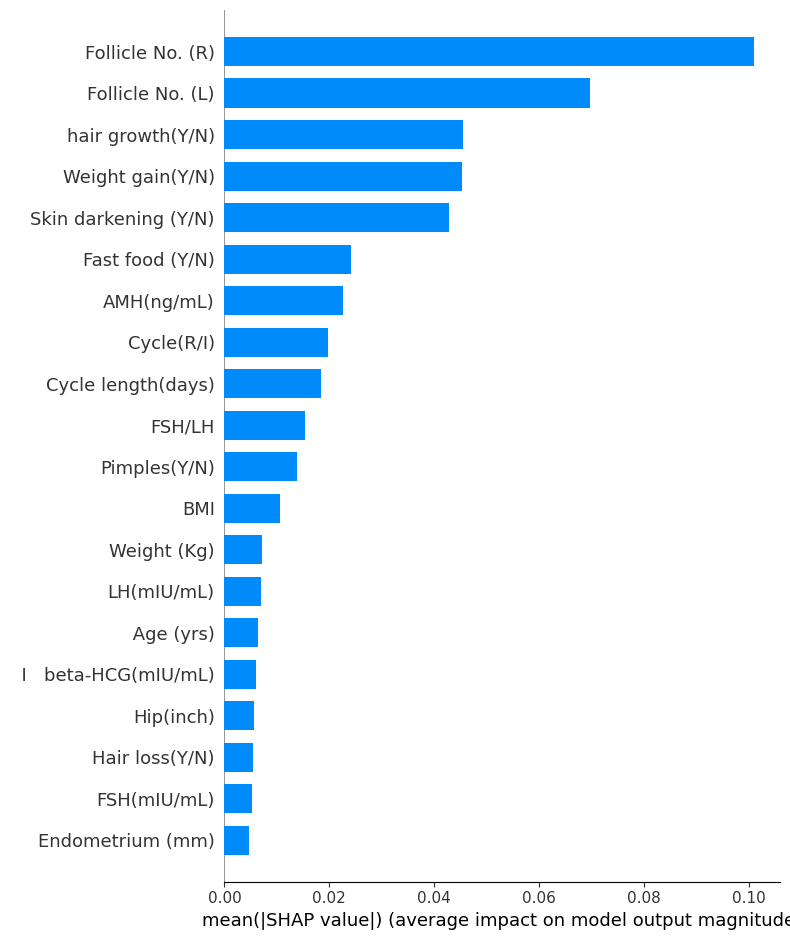

In [48]:
# ✅ SHAP global + local explanation for Random Forest (rf)

# 1) Use the already-trained Random Forest
explain_model = rf

# 2) Create SHAP TreeExplainer (best for tree models like Random Forest)
explainer = shap.TreeExplainer(explain_model)

# Use the same imputed test data for global analysis
X_test_for_shap = X_test_imputed

# 3) Compute SHAP values
shap_values = explainer.shap_values(X_test_for_shap)

print("SHAP values computed!")

# Handle different formats (list vs array, 2D vs 3D)
if isinstance(shap_values, list):
    # binary classification: [class0, class1]
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

# If SHAP returns (samples, features, classes), select class 1
if shap_values_positive.ndim == 3:
    # last dimension = classes
    shap_values_positive = shap_values_positive[:, :, 1]

print("Final SHAP values shape:", shap_values_positive.shape)
print("Expected samples, features:", X_test_for_shap.shape)

# 4) Global feature importance (bar summary plot)
shap.initjs()
shap.summary_plot(
    shap_values_positive,
    X_test_for_shap,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)


In [49]:
import joblib

joblib.dump(rf, "rf_model.pkl")              # Random Forest model
joblib.dump(imputer, "imputer.pkl")          # your SimpleImputer
joblib.dump(feature_names, "feature_names.pkl")  # list of column names

print("Saved rf_model.pkl, imputer.pkl, feature_names.pkl")


Saved rf_model.pkl, imputer.pkl, feature_names.pkl


In [50]:
import joblib

# Save all your trained models
joblib.dump(dt,        "dt_model.pkl")
joblib.dump(svm,       "svm_model.pkl")
joblib.dump(rf,        "rf_model.pkl")
joblib.dump(lr,        "lr_model.pkl")
joblib.dump(knn,       "knn_model.pkl")
joblib.dump(xgb_clf,   "xgb_model.pkl")
joblib.dump(cat_clf,   "cat_model.pkl")

# Save imputer and feature names (very important)
joblib.dump(imputer,       "imputer.pkl")
joblib.dump(feature_names, "feature_names.pkl")  # if you don't have this, use list(X.columns)

print("✅ Saved all models, imputer, and feature names.")


✅ Saved all models, imputer, and feature names.


Raw SHAP values type: <class 'list'>
shap_values_positive shape: (163, 41)
X_test_for_shap shape: (163, 41)
num feature_names: 42
⚠️ Mismatch in feature counts: X=41, SHAP=41, names=42
✅ Using first 41 features consistently for all.
After alignment:
  shap_values_used: (163, 41)
  X_used: (163, 41)
  feature_names_used: 41


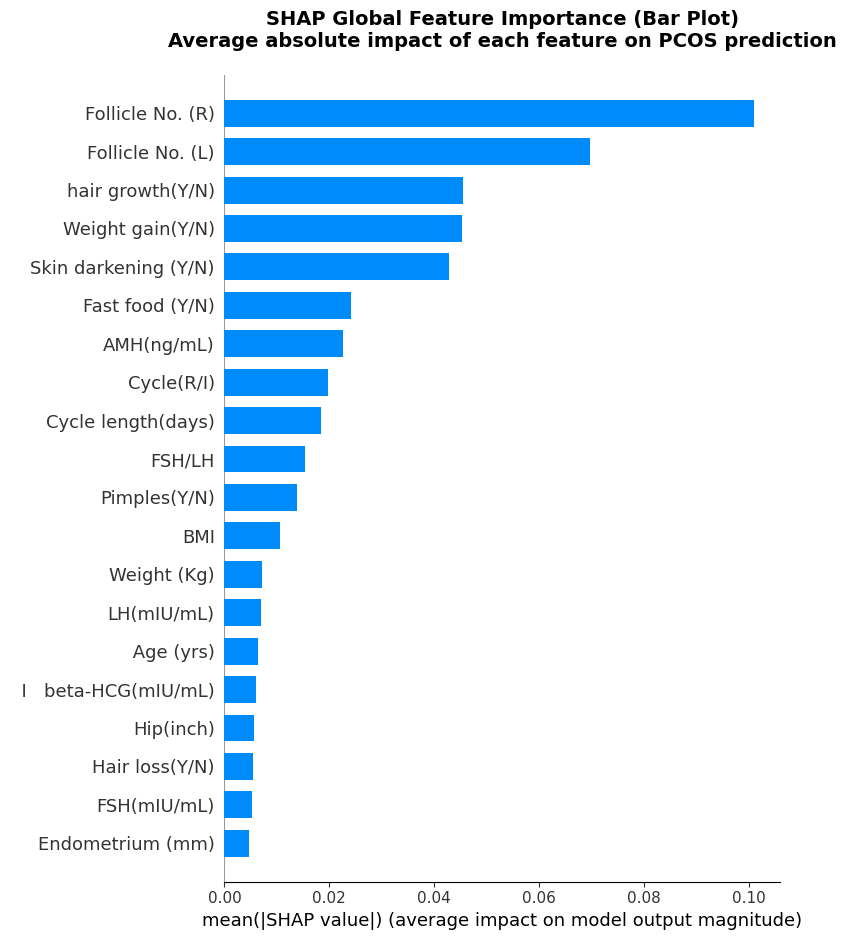

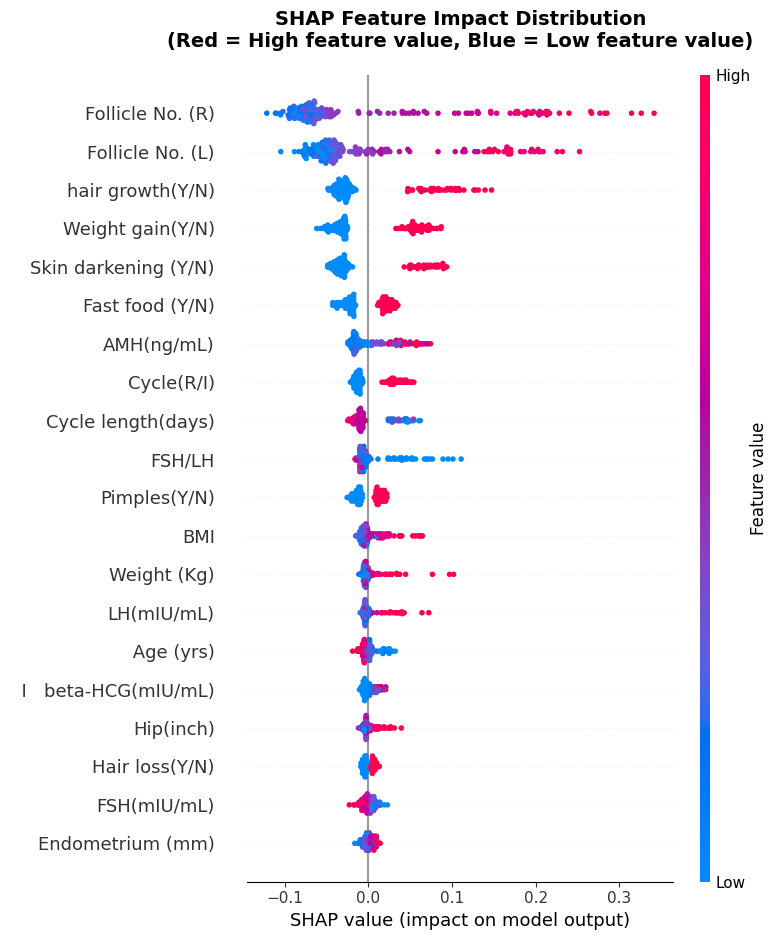


Top features by mean |SHAP|:
                 feature  importance
37      Follicle No. (R)    0.100895
36      Follicle No. (L)    0.069686
28      hair growth(Y/N)    0.045497
27      Weight gain(Y/N)    0.045368
29  Skin darkening (Y/N)    0.042857
32       Fast food (Y/N)    0.024081
22            AMH(ng/mL)    0.022616
8             Cycle(R/I)    0.019656
9     Cycle length(days)    0.018366
17                FSH/LH    0.015443


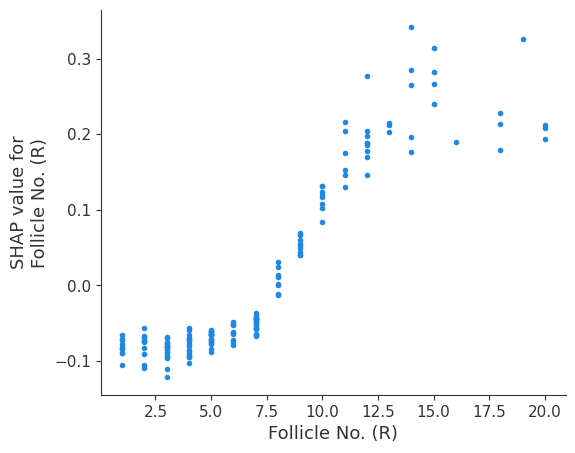

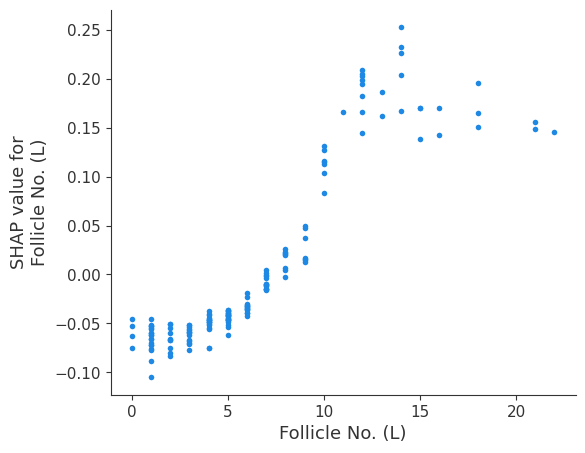

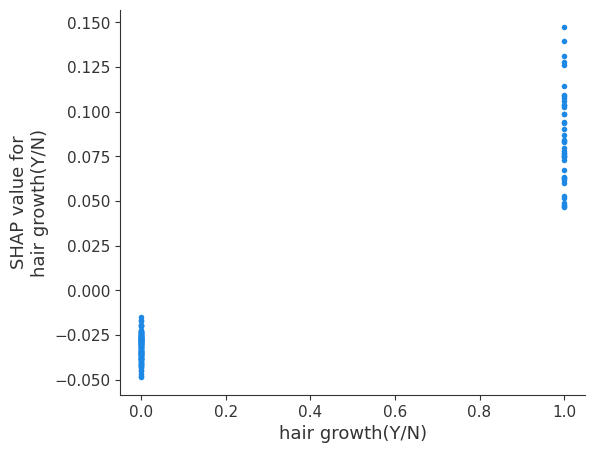

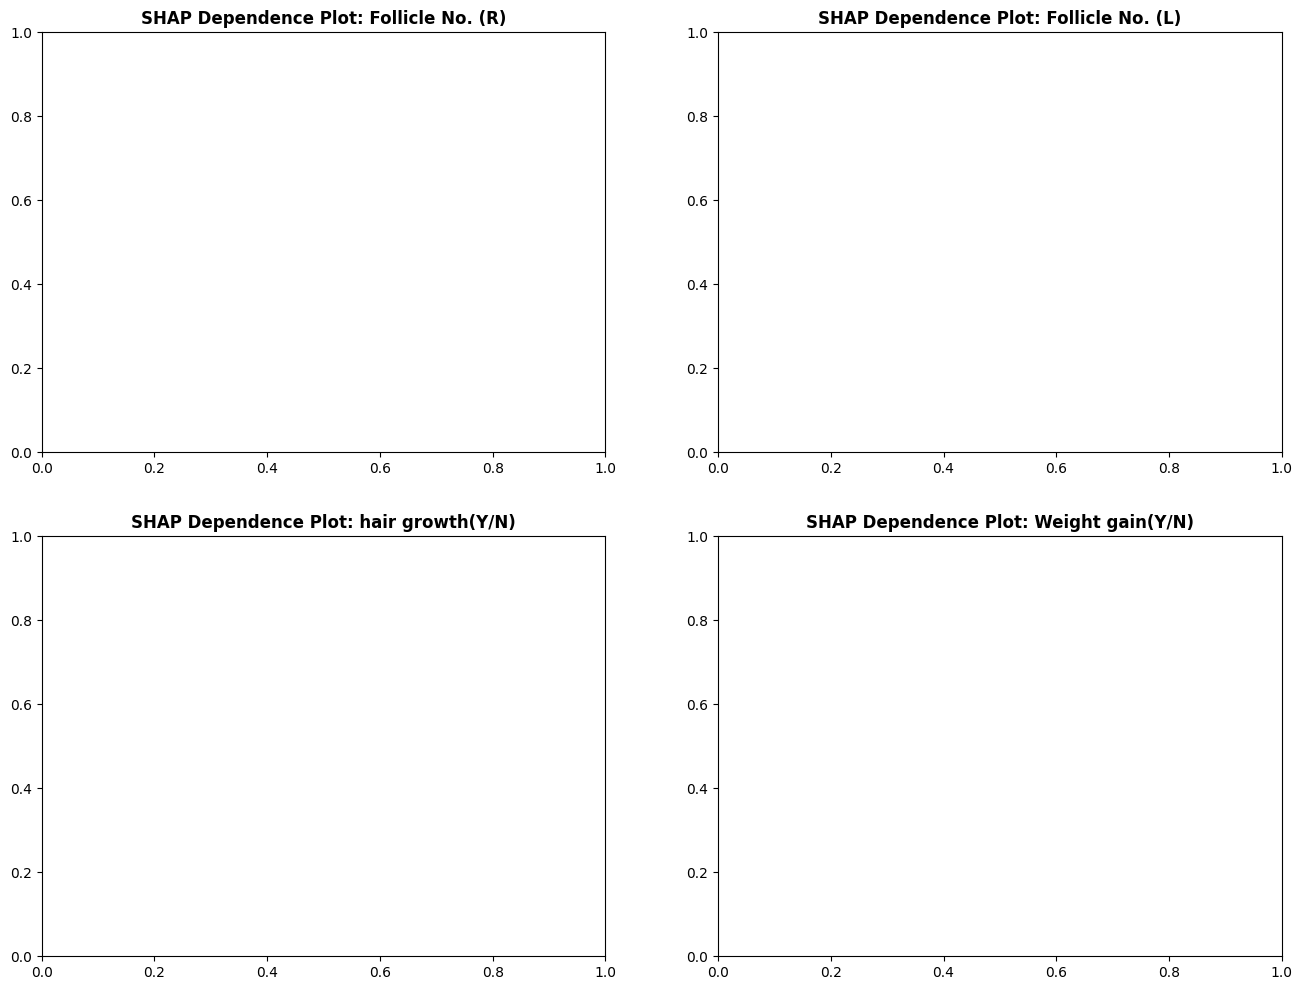

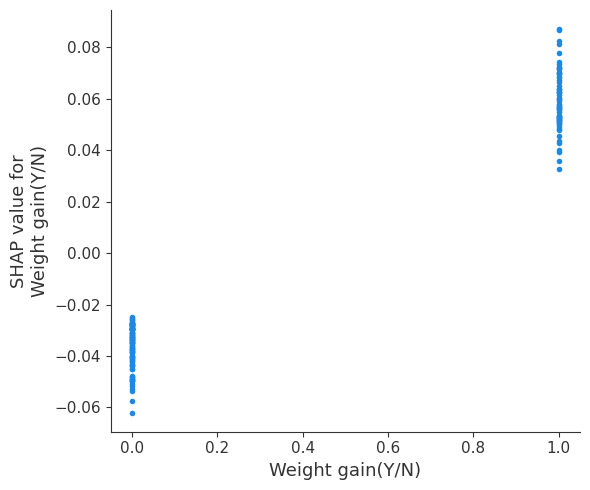


Interpretation for dependence plots:
- X-axis: feature value
- Y-axis: SHAP value (impact on model output)
- Higher SHAP value = higher probability of PCOS

🔍 Analyzing PCOS Positive Case (Test index: 0)
Actual Label:     1
Predicted Label:  1
Prediction Prob.: 0.896


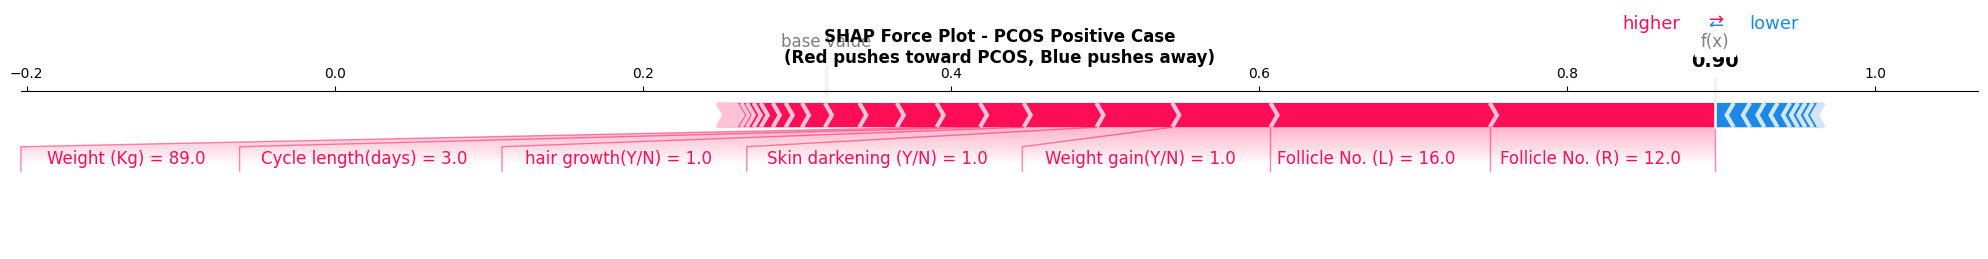

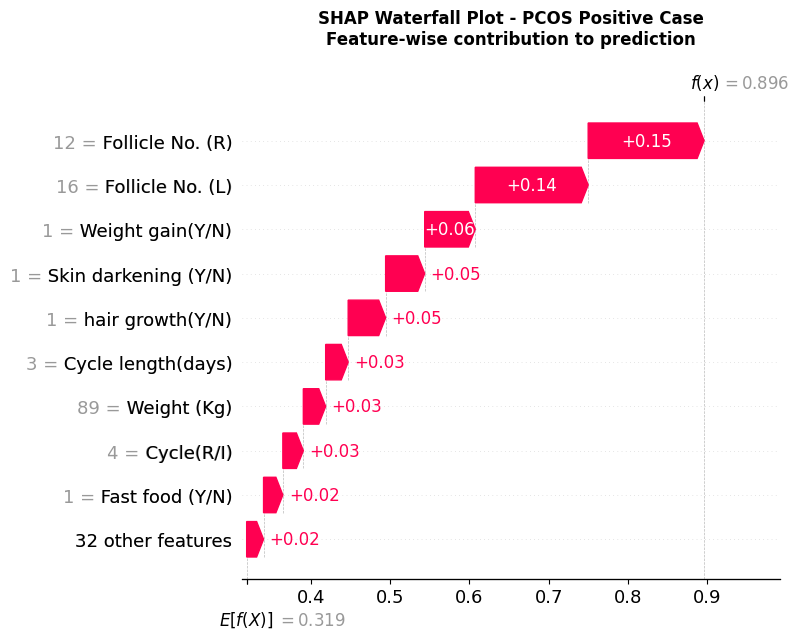

In [51]:
# ✅ Full SHAP explainability for Random Forest (rf)
# Global (bar + dot + dependence) + Local (force + waterfall)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# 0️⃣ Make sure feature names exist
feature_names = X_train.columns.tolist()

# 1️⃣ Create SHAP TreeExplainer for your Random Forest model
explain_model = rf
explainer = shap.TreeExplainer(explain_model)

# Use the imputed test data (same as used for predictions)
X_test_for_shap = X_test_imputed

# 2️⃣ Compute SHAP values
shap_values = explainer.shap_values(X_test_for_shap)
print("Raw SHAP values type:", type(shap_values))

# Handle different formats (list vs array, 2D vs 3D)
if isinstance(shap_values, list):
    # Binary classification: [class 0, class 1]
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

# If SHAP returns (samples, features, classes), select class 1
if shap_values_positive.ndim == 3:
    shap_values_positive = shap_values_positive[:, :, 1]

print("shap_values_positive shape:", shap_values_positive.shape)
print("X_test_for_shap shape:", X_test_for_shap.shape)
print("num feature_names:", len(feature_names))

# 2.1️⃣ Align feature_names, SHAP values, and X_test columns

# If X_test_for_shap is numpy, get number of features from its shape
if isinstance(X_test_for_shap, pd.DataFrame):
    n_features_X = X_test_for_shap.shape[1]
else:
    n_features_X = X_test_for_shap.shape[1]

n_features_shap = shap_values_positive.shape[1]
n_features_names = len(feature_names)

min_len = min(n_features_X, n_features_shap, n_features_names)

if not (n_features_X == n_features_shap == n_features_names):
    print(f"⚠️ Mismatch in feature counts: X={n_features_X}, SHAP={n_features_shap}, names={n_features_names}")
    print(f"✅ Using first {min_len} features consistently for all.")

# Slice everything to the common length
shap_values_used = shap_values_positive[:, :min_len]

if isinstance(X_test_for_shap, pd.DataFrame):
    X_used = X_test_for_shap.iloc[:, :min_len]
else:
    X_used = X_test_for_shap[:, :min_len]

feature_names_used = feature_names[:min_len]

print("After alignment:")
print("  shap_values_used:", shap_values_used.shape)
print("  X_used:", X_used.shape)
print("  feature_names_used:", len(feature_names_used))

# 3️⃣ Global feature importance (bar summary plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_used,
    X_used,
    feature_names=feature_names_used,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title(
    "SHAP Global Feature Importance (Bar Plot)\n"
    "Average absolute impact of each feature on PCOS prediction",
    fontsize=14,
    fontweight="bold",
    pad=20
)
plt.tight_layout()
plt.show()

# 4️⃣ Detailed global summary (dot plot)
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values_used,
    X_used,
    feature_names=feature_names_used,
    max_display=20,
    show=False
)
plt.title(
    "SHAP Feature Impact Distribution\n"
    "(Red = High feature value, Blue = Low feature value)",
    fontsize=14,
    fontweight="bold",
    pad=20
)
plt.tight_layout()
plt.show()

# 5️⃣ Top 4 features (by mean |SHAP|) for dependence plots
importance_values = np.mean(np.abs(shap_values_used), axis=0)

feature_importance = pd.DataFrame({
    "feature": feature_names_used,
    "importance": importance_values
}).sort_values("importance", ascending=False)

print("\nTop features by mean |SHAP|:")
print(feature_importance.head(10))

top_4_features = feature_importance.head(4)["feature"].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_4_features):
    try:
        plt.sca(axes[idx])
        shap.dependence_plot(
            feature,
            shap_values_used,
            X_used,
            feature_names=feature_names_used,
            interaction_index=None,
            show=False
        )
        axes[idx].set_title(
            f"SHAP Dependence Plot: {feature}",
            fontsize=12,
            fontweight="bold"
        )
    except Exception as e:
        print(f"Error plotting {feature}: {str(e)}")
        axes[idx].text(
            0.5, 0.5,
            f"Error plotting {feature}",
            ha="center", va="center",
            transform=axes[idx].transAxes
        )

plt.tight_layout()
plt.show()

print("\nInterpretation for dependence plots:")
print("- X-axis: feature value")
print("- Y-axis: SHAP value (impact on model output)")
print("- Higher SHAP value = higher probability of PCOS")

# 6️⃣ Local explanation for one PCOS positive case

# Find indices of PCOS-positive cases in test set
pcos_positive_indices = np.where(y_test.values == 1)[0]

if len(pcos_positive_indices) > 0:
    sample_idx = pcos_positive_indices[0]  # take first PCOS-positive case

    # Recompute RF predictions on imputed test data (just for clarity)
    y_pred_rf = rf.predict(X_test_imputed)
    y_proba_rf = rf.predict_proba(X_test_imputed)[:, 1]

    print(f"\n🔍 Analyzing PCOS Positive Case (Test index: {sample_idx})")
    print(f"Actual Label:     {y_test.iloc[sample_idx]}")
    print(f"Predicted Label:  {y_pred_rf[sample_idx]}")
    print(f"Prediction Prob.: {y_proba_rf[sample_idx]:.3f}")

    # Base value for class 1 (PCOS)
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[1]
    else:
        base_value = explainer.expected_value

    # 6.1️⃣ Force plot for this patient
    shap.initjs()
    shap.force_plot(
        base_value,
        shap_values_used[sample_idx, :],
        X_test.iloc[sample_idx, :min_len],  # match the same first min_len features
        matplotlib=True,
        show=False
    )
    plt.title(
        "SHAP Force Plot - PCOS Positive Case\n"
        "(Red pushes toward PCOS, Blue pushes away)",
        fontsize=12,
        fontweight="bold",
        pad=20
    )
    plt.tight_layout()
    plt.show()

    # 6.2️⃣ Waterfall plot for this patient
    explanation = shap.Explanation(
        values=shap_values_used[sample_idx, :],
        base_values=base_value,
        data=X_test.iloc[sample_idx, :min_len].values,
        feature_names=feature_names_used
    )

    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(explanation, show=False)
    plt.title(
        "SHAP Waterfall Plot - PCOS Positive Case\n"
        "Feature-wise contribution to prediction",
        fontsize=12,
        fontweight="bold",
        pad=20
    )
    plt.tight_layout()
    plt.show()

else:
    print("No PCOS positive cases found in y_test – cannot create local SHAP plots.")


In [52]:
# 🌸 Beautiful PCOS UI + Local Explainability (SHAP)

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ✨ ULTRA CUTE & PREMIUM STYLING ✨
custom_css = """
<style>
@import url('https://fonts.googleapis.com/css2?family=Nunito:wght@400;600;700;800&family=Pacifico&family=Quicksand:wght@400;500;600;700&display=swap');

@keyframes float {
    0%, 100% { transform: translateY(0px); }
    50% { transform: translateY(-10px); }
}

@keyframes shimmer {
    0% { background-position: -1000px 0; }
    100% { background-position: 1000px 0; }
}

@keyframes pulse {
    0%, 100% { transform: scale(1); }
    50% { transform: scale(1.05); }
}

@keyframes fadeInUp {
    from {
        opacity: 0;
        transform: translateY(30px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

.pcos-main-container {
    background: linear-gradient(135deg, #fff0f5 0%, #ffe4e9 25%, #ffd6e0 50%, #ffe4e9 75%, #fff0f5 100%);
    border-radius: 30px;
    padding: 35px;
    border: 3px solid #ffb3c6;
    box-shadow: 0 12px 40px rgba(255, 105, 180, 0.35), 
                0 0 0 1px rgba(255, 255, 255, 0.8) inset;
    max-width: 1150px;
    margin: 20px auto;
    position: relative;
    animation: fadeInUp 0.6s ease-out;
}

.pcos-main-container::before {
    content: '🌸';
    position: absolute;
    top: 20px;
    left: 20px;
    font-size: 40px;
    opacity: 0.3;
    animation: float 3s ease-in-out infinite;
}

.pcos-main-container::after {
    content: '🦋';
    position: absolute;
    top: 20px;
    right: 20px;
    font-size: 40px;
    opacity: 0.3;
    animation: float 3s ease-in-out infinite 1.5s;
}

.pcos-header {
    text-align: center;
    margin-bottom: 30px;
    padding: 30px;
    background: linear-gradient(135deg, #ff1493 0%, #ff69b4 50%, #ffb6c1 100%);
    border-radius: 25px;
    box-shadow: 0 8px 25px rgba(255, 20, 147, 0.4),
                0 0 60px rgba(255, 105, 180, 0.3);
    position: relative;
    overflow: hidden;
    animation: pulse 2s ease-in-out infinite;
}

.pcos-header::before {
    content: '';
    position: absolute;
    top: -50%;
    left: -50%;
    width: 200%;
    height: 200%;
    background: linear-gradient(
        45deg,
        transparent 30%,
        rgba(255, 255, 255, 0.3) 50%,
        transparent 70%
    );
    animation: shimmer 3s infinite;
}

.pcos-title {
    font-family: 'Pacifico', 'Nunito', cursive;
    font-size: 42px;
    font-weight: 400;
    color: #ffffff;
    margin: 0 0 12px 0;
    text-shadow: 3px 3px 6px rgba(0,0,0,0.2),
                 0 0 20px rgba(255, 255, 255, 0.5);
    letter-spacing: 1px;
    position: relative;
    z-index: 1;
}

.pcos-subtitle {
    font-family: 'Quicksand', 'Nunito', sans-serif;
    font-size: 17px;
    color: #ffffff;
    margin: 0;
    font-weight: 600;
    text-shadow: 2px 2px 4px rgba(0,0,0,0.15);
    position: relative;
    z-index: 1;
}

.pcos-section {
    background: linear-gradient(135deg, #ffffff 0%, #fff5f8 100%);
    border-radius: 22px;
    padding: 25px 30px;
    margin: 18px 0;
    border: 2px solid #ffc0cb;
    box-shadow: 0 6px 20px rgba(255, 192, 203, 0.3),
                0 0 0 1px rgba(255, 255, 255, 0.8) inset;
    position: relative;
    transition: transform 0.3s ease, box-shadow 0.3s ease;
}

.pcos-section:hover {
    transform: translateY(-2px);
    box-shadow: 0 8px 25px rgba(255, 192, 203, 0.4),
                0 0 0 1px rgba(255, 255, 255, 0.8) inset;
}

.pcos-section-title {
    font-family: 'Quicksand', 'Nunito', sans-serif;
    font-size: 22px;
    font-weight: 700;
    background: linear-gradient(135deg, #ff1493 0%, #ff69b4 100%);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;
    margin: 0 0 15px 0;
    display: flex;
    align-items: center;
    gap: 10px;
}

.pcos-note {
    font-family: 'Quicksand', 'Nunito', sans-serif;
    font-size: 14px;
    color: #9c5c7f;
    background: linear-gradient(135deg, #fff9fc 0%, #ffe8f0 100%);
    padding: 15px 20px;
    border-radius: 15px;
    border-left: 5px solid #ffb3d9;
    margin: 12px 0;
    line-height: 1.7;
    box-shadow: 0 3px 10px rgba(255, 182, 217, 0.2);
}

.result-card {
    background: linear-gradient(135deg, #fff9fc 0%, #ffe8f0 100%);
    border-radius: 16px;
    padding: 20px;
    border: 2px solid #ffd6e5;
    margin: 15px 0;
    box-shadow: 0 6px 16px rgba(255, 105, 180, 0.2);
}

.result-positive {
    background: linear-gradient(135deg, #fff0f5 0%, #ffe0ea 100%);
    border-color: #ffb3c6;
}

.result-negative {
    background: linear-gradient(135deg, #f0fff4 0%, #e0ffe8 100%);
    border-color: #b3ffc6;
}

.result-emoji {
    font-size: 48px;
    text-align: center;
    margin: 10px 0;
}

.result-label {
    font-family: 'Nunito', sans-serif;
    font-size: 24px;
    font-weight: 700;
    text-align: center;
    margin: 10px 0;
}

.result-label-positive {
    color: #ff1493;
}

.result-label-negative {
    color: #2ecc71;
}

.result-details {
    font-family: 'Nunito', sans-serif;
    font-size: 15px;
    color: #5b3750;
    line-height: 1.8;
    margin: 15px 0;
}

.widget-label {
    font-family: 'Nunito', sans-serif;
    font-weight: 600;
    color: #d81b60;
}

.explanation-table {
    background: white;
    border-radius: 12px;
    overflow: hidden;
    box-shadow: 0 2px 8px rgba(255, 105, 180, 0.15);
}

.cute-divider {
    text-align: center;
    margin: 20px 0;
    font-size: 24px;
    opacity: 0.6;
}

/* Matplotlib plot styling */
.output_png {
    background: white;
    border-radius: 12px;
    padding: 15px;
    box-shadow: 0 4px 12px rgba(255, 192, 203, 0.2);
}
</style>
"""
display(HTML(custom_css))

# 0️⃣ Feature names from training data
feature_names = X_train.columns.tolist()

# 1️⃣ SHAP explainer for the trained Random Forest
shap_explainer_ui = shap.TreeExplainer(rf)

# 2️⃣ Create input widgets with enhanced styling
feature_widgets = {}

for col in feature_names:
    col_series = X_train[col]
    
    # Numeric features
    if pd.api.types.is_numeric_dtype(col_series):
        default_val = col_series.median()
        
        if pd.api.types.is_integer_dtype(col_series):
            w = widgets.IntText(
                description=col[:20],
                value=int(default_val),
                layout=widgets.Layout(width='340px')
            )
        else:
            w = widgets.FloatText(
                description=col[:20],
                value=float(default_val),
                layout=widgets.Layout(width='340px')
            )
    else:
        # Categorical: dropdown with seen values
        options = sorted(col_series.dropna().unique().tolist())
        w = widgets.Dropdown(
            options=options,
            description=col[:20],
            layout=widgets.Layout(width='340px')
        )
    
    w.style.description_width = '160px'
    feature_widgets[col] = w

# 3️⃣ Beautiful button + output
predict_button = widgets.Button(
    description="✨ Predict & Explain ✨",
    button_style="danger",  # Pink-ish theme
    layout=widgets.Layout(width='240px', height='50px'),
    style={'font_weight': 'bold', 'font_size': '14px'}
)
output = widgets.Output()

# 4️⃣ Callback for prediction + SHAP explanation
def on_predict_clicked(b):
    with output:
        clear_output()
        
        # Collect user inputs
        input_data = {}
        for col, w in feature_widgets.items():
            input_data[col] = w.value
        
        input_df = pd.DataFrame([input_data], columns=feature_names)
        
        # Same preprocessing as training
        input_imputed = imputer.transform(input_df)
        
        # Model prediction
        pred = rf.predict(input_imputed)[0]
        proba = rf.predict_proba(input_imputed)[0][1]  # class 1 = PCOS
        
        # Beautiful result display
        if pred == 1:
            label = "PCOS / PCOD Likely"
            emoji = "🌷"
            card_class = "result-positive"
            label_class = "result-label-positive"
            message = "The model suggests PCOS indicators are present. Remember, this is just a prediction tool! 💕"
        else:
            label = "No PCOS / PCOD Likely"
            emoji = "🌸"
            card_class = "result-negative"
            label_class = "result-label-negative"
            message = "The model suggests low PCOS indicators. Keep up your healthy habits! 🌟"
        
        display(HTML(f"""
        <div class="pcos-main-container">
            <div class="pcos-section">
                <div class="pcos-section-title">💁‍♀️ Your Health Details</div>
                <div class="pcos-note">
                    Here's a summary of the information you provided. Double-check to ensure accuracy!
                </div>
            </div>
        </div>
        """))
        display(input_df.style.set_properties(**{
            'background-color': '#fff9fc',
            'color': '#5b3750',
            'border-color': '#ffc0cb'
        }).set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#ff69b4'), ('color', 'white'), ('font-weight', 'bold')]}
        ]))

        display(HTML(f"""
        <div class="pcos-main-container">
            <div class="cute-divider">✿ ❀ ✿</div>
            
            <div class="result-card {card_class}">
                <div class="result-emoji">{emoji}</div>
                <div class="result-label {label_class}">{label}</div>
                <div class="result-details">
                    <b>🔮 Confidence Score:</b> {proba:.1%} probability of PCOS<br>
                    <b>💭 What this means:</b> {message}
                </div>
                <div class="pcos-note" style="margin-top: 15px;">
                    <b>⚠️ Important Reminder:</b> This is an AI-based estimation tool for educational purposes only. 
                    Always consult with a qualified gynecologist or healthcare professional for proper diagnosis 
                    and treatment. Your health journey is unique! 💖
                </div>
            </div>
        </div>
        """))
        
        # 🔍 SHAP values for this single input
        shap_values_single = shap_explainer_ui.shap_values(input_imputed)
        
        # Handle different SHAP formats
        if isinstance(shap_values_single, list):
            shap_pos = shap_values_single[1][0]
        else:
            shap_arr = np.array(shap_values_single)
            if shap_arr.ndim == 2:
                shap_pos = shap_arr[0]
            elif shap_arr.ndim == 1:
                shap_pos = shap_arr
            else:
                shap_pos = shap_arr[0, :, 1]
        
        shap_pos = np.array(shap_pos)

        # Align lengths
        n_names = len(feature_names)
        n_input = input_df.shape[1]
        n_shap = shap_pos.shape[0]
        min_len = min(n_names, n_input, n_shap)

        if not (n_names == n_input == n_shap):
            print(f"⚠️ Alignment: Using {min_len} features for explanation.\n")

        feature_names_used = feature_names[:min_len]
        values_used = input_df.iloc[0, :min_len].values
        shap_used = shap_pos[:min_len]

        # Build local explanation table
        local_importance = pd.DataFrame({
            "Feature": feature_names_used,
            "Your Value": values_used,
            "Impact Score": shap_used,
            "Importance": np.abs(shap_used)
        }).sort_values("Importance", ascending=False)
        
        display(HTML(f"""
        <div class="pcos-main-container">
            <div class="cute-divider">✿ ❀ ✿</div>
            
            <div class="pcos-section">
                <div class="pcos-section-title">💡 Why This Prediction?</div>
                <div class="pcos-note">
                    <b>Understanding Your Results:</b><br>
                    • <b>Positive scores</b> (pink bars →) push the prediction toward PCOS<br>
                    • <b>Negative scores</b> (← teal bars) push the prediction away from PCOS<br>
                    • Larger bars = stronger influence on the prediction
                </div>
                <br>
                <div style="font-weight: 600; color: #d81b60; margin-bottom: 10px;">
                    🔝 Top 10 Most Influential Factors:
                </div>
            </div>
        </div>
        """))
        
        display(local_importance.head(10)[["Feature", "Your Value", "Impact Score"]].style.set_properties(**{
            'background-color': '#fff9fc',
            'color': '#5b3750',
            'border-color': '#ffc0cb',
            'text-align': 'left'
        }).set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#ff69b4'), ('color', 'white'), 
                                         ('font-weight', 'bold'), ('text-align', 'left')]}
        ]).format({'Impact Score': '{:.4f}'}))
        
        # Beautiful bar plot
        top_k = 10
        top_local = local_importance.head(top_k).iloc[::-1]
        
        plt.style.use('seaborn-v0_8-pastel')
        fig, ax = plt.subplots(figsize=(10, 6))
        
        colors = ['#ff69b4' if x > 0 else '#20b2aa' for x in top_local["Impact Score"]]
        bars = ax.barh(top_local["Feature"], top_local["Impact Score"], color=colors, alpha=0.8)
        
        # Add gradient effect
        for bar, color in zip(bars, colors):
            bar.set_edgecolor(color)
            bar.set_linewidth(1.5)
        
        ax.axvline(0, color='#696969', linewidth=2, linestyle='--', alpha=0.5)
        ax.set_xlabel('Impact on PCOS Prediction', fontsize=13, fontweight='bold', color='#5b3750')
        ax.set_title('🌸 Feature Importance Breakdown 🌸', fontsize=15, fontweight='bold', 
                     color='#ff1493', pad=20)
        ax.tick_params(colors='#5b3750')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#ffb3d9')
        ax.spines['bottom'].set_color('#ffb3d9')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#ff69b4', alpha=0.8, label='Pushes toward PCOS'),
            Patch(facecolor='#20b2aa', alpha=0.8, label='Pushes away from PCOS')
        ]
        ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)
        
        plt.tight_layout()
        plt.show()
        
        display(HTML("""
        <div class="pcos-main-container">
            <div class="pcos-note" style="text-align: center; font-size: 14px;">
                <b>💝 Remember:</b> You're taking a positive step by learning about your health! 
                This tool is here to support and inform you, but professional medical advice is irreplaceable. 
                Stay empowered and take care! 🌟
            </div>
        </div>
        """))

# Connect button
predict_button.on_click(on_predict_clicked)

# 5️⃣ Beautiful layout
form_items = [w for w in feature_widgets.values()]

input_grid = widgets.GridBox(
    children=form_items,
    layout=widgets.Layout(
        grid_template_columns="repeat(2, 380px)",
        grid_gap="12px 20px",
        margin="10px 0 15px 0"
    )
)

header = widgets.HTML("""
<div class="pcos-main-container">
    <div class="pcos-header">
        <div class="pcos-title">🌸 PCOS Wellness Assistant 🌸</div>
        <div class="pcos-subtitle">
            A caring, AI-powered tool to help understand your PCOS risk factors
        </div>
    </div>
    
    <div class="pcos-section">
        <div class="pcos-section-title">🧬 Enter Your Health Information</div>
        <div class="pcos-note">
            Fill in your health details below. You can adjust values based on recent lab reports or 
            medical consultations. All data is processed privately and used only for this prediction. 💖
        </div>
    </div>
</div>
""")

button_container = widgets.HBox(
    [predict_button],
    layout=widgets.Layout(justify_content='center', margin='20px 0')
)

card_content = widgets.VBox([
    input_grid,
    button_container
])

outer_box = widgets.VBox([
    header,
    card_content,
    widgets.HTML("<div style='height: 20px;'></div>"),
    output
])

display(outer_box)